Connecting to radio://0/80/2M/E7E7E7E701
Connected to radio://0/80/2M/E7E7E7E701
Waiting for estimator to find position...
Setting position (0, 0, 1)
Setting position (0.2, 0.2, 1)
Setting position (0.2, -0.2, 0.9)
Setting position (-0.2, 0.2, 0.5)
Setting position (-0.2, -0.2, 1)
Setting position (0, 0, 1)
Setting position (0, 0, 0.2)
Landing


<ipython-input-1-6cbce016e63a>:193: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


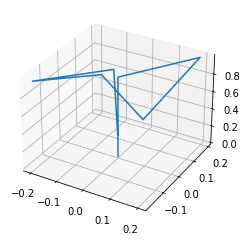

In [1]:
# -*- coding: utf-8 -*-
#
"""
Simple example that connects to one crazyflie, sets the initial position
flies towards specified positions in sequence using onboard velocity control.
Using synchronous crazyflie classes suitable to control a single drone.
Works best with lighthouse/loco positioning systems.
"""
import math
import time

# Primarily see __init__.py in cfsim/crazyflie/ to add functionality to simulator
import cfsim.crtp as crtp
from cfsim.crazyflie import Crazyflie
from cfsim.crazyflie.log import LogConfig
from cfsim.crazyflie.syncCrazyflie import SyncCrazyflie
from cfsim.crazyflie.syncLogger import SyncLogger

#import cflib.crtp as crtp
# from cflib.crazyflie import Crazyflie
# from cflib.crazyflie.log import LogConfig
# from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
# from cflib.crazyflie.syncLogger import SyncLogger

logdata = {}

# URI to the Crazyflie to connect to
uri = 'radio://0/80/2M/E7E7E7E701'
# uri = 'radio://0/80/2M/E7E7E7E702'
# uri = 'radio://0/90/2M/E7E7E7E703'
# uri = 'radio://0/90/2M/E7E7E7E704'

# Change the sequence according to your setup
#             x    y    z
sequence = [
    (0, 0, 1),
    (0.2, 0.2, 1),
    (0.2, -0.2, 0.9),
    (-0.2, 0.2, 0.5),
    (-0.2, -0.2, 1),
    (0, 0, 1),
    (0, 0, 0.2),
]
# initial = (2.5, 1.4, 0) # UWB
initial = (0.0, 0, 0.0) # Lighthouse


def wait_for_position_estimator(scf):
    print('Waiting for estimator to find position...')

    log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
    log_config.add_variable('kalman.varPX', 'float')
    log_config.add_variable('kalman.varPY', 'float')
    log_config.add_variable('kalman.varPZ', 'float')

    var_y_history = [1000] * 10
    var_x_history = [1000] * 10
    var_z_history = [1000] * 10

    threshold = 0.001

    with SyncLogger(scf, log_config) as logger:
        for log_entry in logger:
            data = log_entry[1]
            var_x_history.append(data['kalman.varPX'])
            var_x_history.pop(0)
            var_y_history.append(data['kalman.varPY'])
            var_y_history.pop(0)
            var_z_history.append(data['kalman.varPZ'])
            var_z_history.pop(0)
            
            min_x = min(var_x_history)
            max_x = max(var_x_history)
            min_y = min(var_y_history)
            max_y = max(var_y_history)
            min_z = min(var_z_history)
            max_z = max(var_z_history)
            
            if (max_x - min_x) < threshold and (
                    max_y - min_y) < threshold and (
                    max_z - min_z) < threshold:
                break


def set_initial_position(scf):
    scf.cf.param.set_value('kalman.initialX', initial[0])
    scf.cf.param.set_value('kalman.initialY', initial[1])
    scf.cf.param.set_value('kalman.initialZ', initial[2])

def reset_estimator(scf):
    cf = scf.cf
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')

    wait_for_position_estimator(cf)


def run_sequence(scf, logger, sequence):
    cf = scf.cf

    startTime = time.time( )
    sequencePos = 0

    # Set starting position
    position = sequence[sequencePos]
    print('Setting position {}'.format(position))

    for log_entry in logger: #Synchronous list (runs when a new position is recieved, otherwise blocks)
        timestamp = log_entry[0]
        data = log_entry[1]
        logconf_name = log_entry[2]

        #print('[%d][%s]: %s' % (timestamp, logconf_name, data))

        # Determine position reference based on time
        relativeTime = time.time()-startTime
        if relativeTime > (sequencePos+1)*5: # Fly to each point for 5 seconds
            sequencePos += 1

            if sequencePos >= len(sequence):
                break

            position = sequence[sequencePos]
            print('Setting position {}'.format(position))

        # Desired position
        x_des = position[0] + initial[0]
        y_des = position[1] + initial[1]
        z_des = position[2] + initial[2]

        # Estimated position
        x = data['kalman.stateX']
        y = data['kalman.stateY']
        z = data['kalman.stateZ']

        # Compute velocity (P controller)
        vmax = 0.4 # Maximum velocity 
        K = 1 # Controller gain
        x
        xe = x-x_des
        ye = y-y_des
        ze = z-z_des
        d = math.sqrt(xe**2+ye**2+ze**2)
        v = K*d;
        v = min(vmax,v)
        vx = -v*xe/d
        vy = -v*ye/d
        vz = -v*ze/d

        # Send velocity
        cf.commander.send_velocity_world_setpoint(vx, vy, vz, 0)

        # Log some data
        logdata[uri]['x'].append(x)
        logdata[uri]['y'].append(y)
        logdata[uri]['z'].append(z)

    print('Landing')
    for i in range(20):
        cf.commander.send_velocity_world_setpoint(0, 0, -0.1, 0)
        time.sleep(0.1)
    cf.commander.send_stop_setpoint()
    # Make sure that the last packet leaves before the link is closed
    # since the message queue is not flushed before closing
    time.sleep(0.1)


if __name__ == '__main__':
    logdata[uri] = {'x':[],'y':[],'z':[]}

    crtp.init_drivers(enable_debug_driver=False)

    # Set logging ()
    log_config = LogConfig(name='Position', period_in_ms=50)
    log_config.add_variable('kalman.stateX', 'float')
    log_config.add_variable('kalman.stateY', 'float')
    log_config.add_variable('kalman.stateZ', 'float')

    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        set_initial_position(scf)
        reset_estimator(scf)


        with SyncLogger(scf, log_config) as logger:
            run_sequence(scf, logger, sequence)


    # Plot
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(logdata[uri]['x'], logdata[uri]['y'], logdata[uri]['z'])
    plt.show( )